In [18]:
%load_ext ipydex.displaytools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [2]:
# Source: https://cloudstor.aarnet.edu.au/plus/index.php/s/2DhnLGDdEECo4ys?path=%2FUNSW-NB15%20-%20CSV%20Files%2Fa%20part%20of%20training%20and%20testing%20set
data = pd.read_csv('./UNSW_NB15_training-set.csv')
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


<AxesSubplot:title={'center':'Correlation with Attack Category'}>

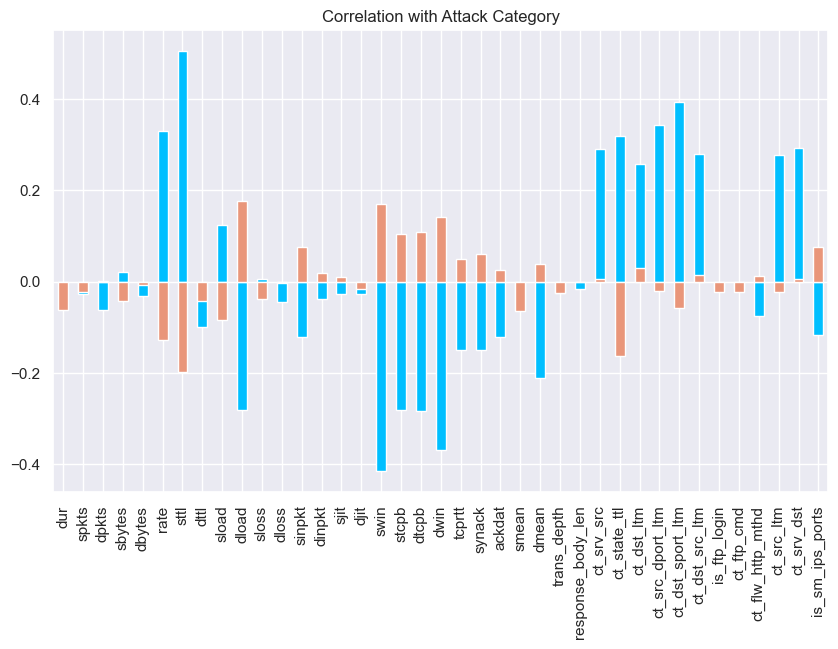

In [11]:
df = data.drop(['id'], axis=1)

attack_le = LabelEncoder()
df['attack_cat'] = attack_le.fit_transform(df['attack_cat'])

df.drop(['label','attack_cat'], axis=1).corrwith(df['label']).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Malicious Label", color="deepskyblue")
df.drop(['label','attack_cat'], axis=1).corrwith(df['attack_cat']).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Attack Category", color="darksalmon")



<AxesSubplot:>

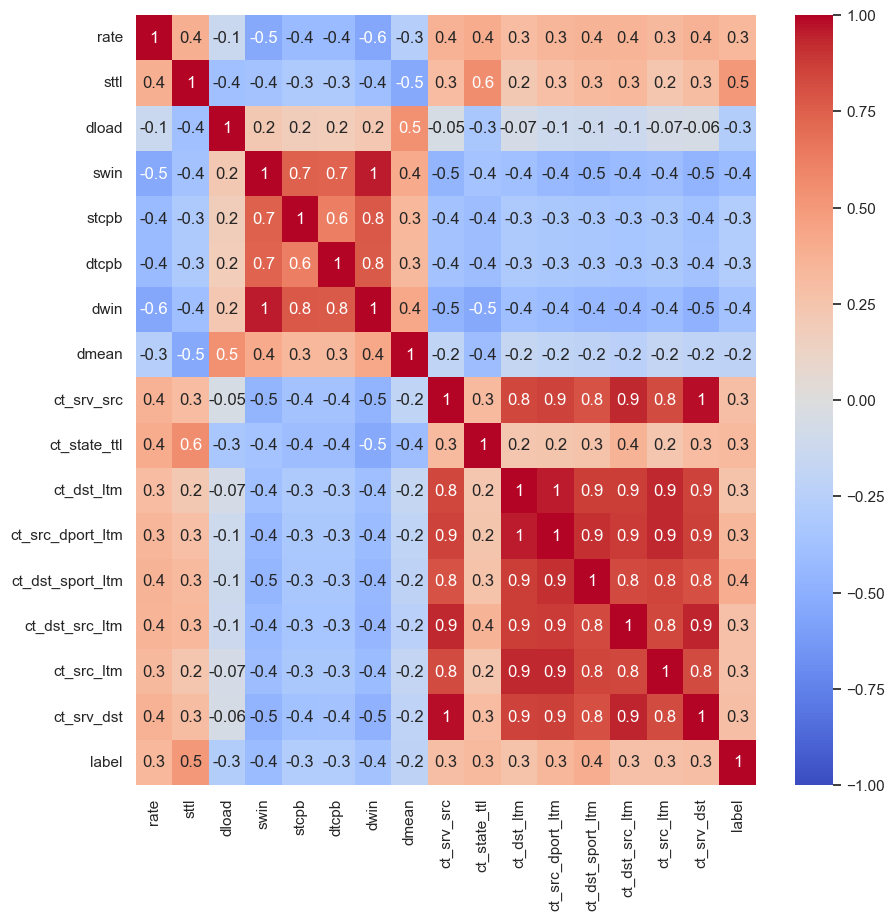

In [23]:
df_label = df.drop(
    [k for k,v in  (df.drop(['label','attack_cat'], axis=1).corrwith(df['label']).abs().sort_values(ascending=True) < 0.2).items()  if v],
    axis=1)
df_label = df_label.drop(['attack_cat','state', 'proto', 'service'], axis=1)

sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_label.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

In [15]:
df_label_lesscorr = df_label[['rate','sttl','dload','swin','dmean','ct_state_ttl','ct_dst_src_ltm','label']]
df_label_lesscorr.head()

,rate,sttl,dload,swin,dmean,ct_state_ttl,ct_dst_src_ltm,label
0,90909.0902,254,0.0,0,0,2,2,0
1,125000.0003,254,0.0,0,0,2,2,0
2,200000.0051,254,0.0,0,0,2,3,0
3,166666.6608,254,0.0,0,0,2,3,0
4,100000.0025,254,0.0,0,0,2,3,0


0.6935689560940062


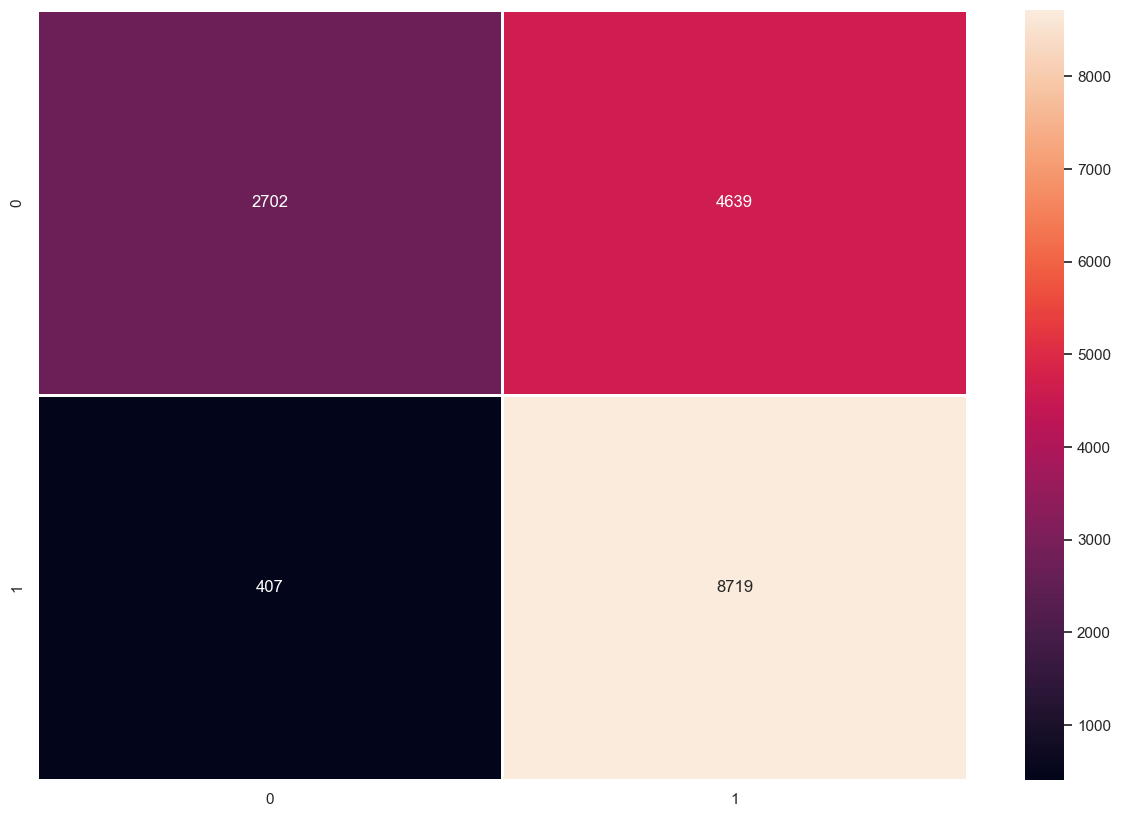

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df_label_lesscorr.drop(['label'], axis=1).to_numpy(), df_label_lesscorr['label'], test_size=0.2)

nb_label = GaussianNB().fit(X_train,y_train)
y_pred = nb_label.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
print(accuracy_score(y_test, y_pred))

0.6848849213578673


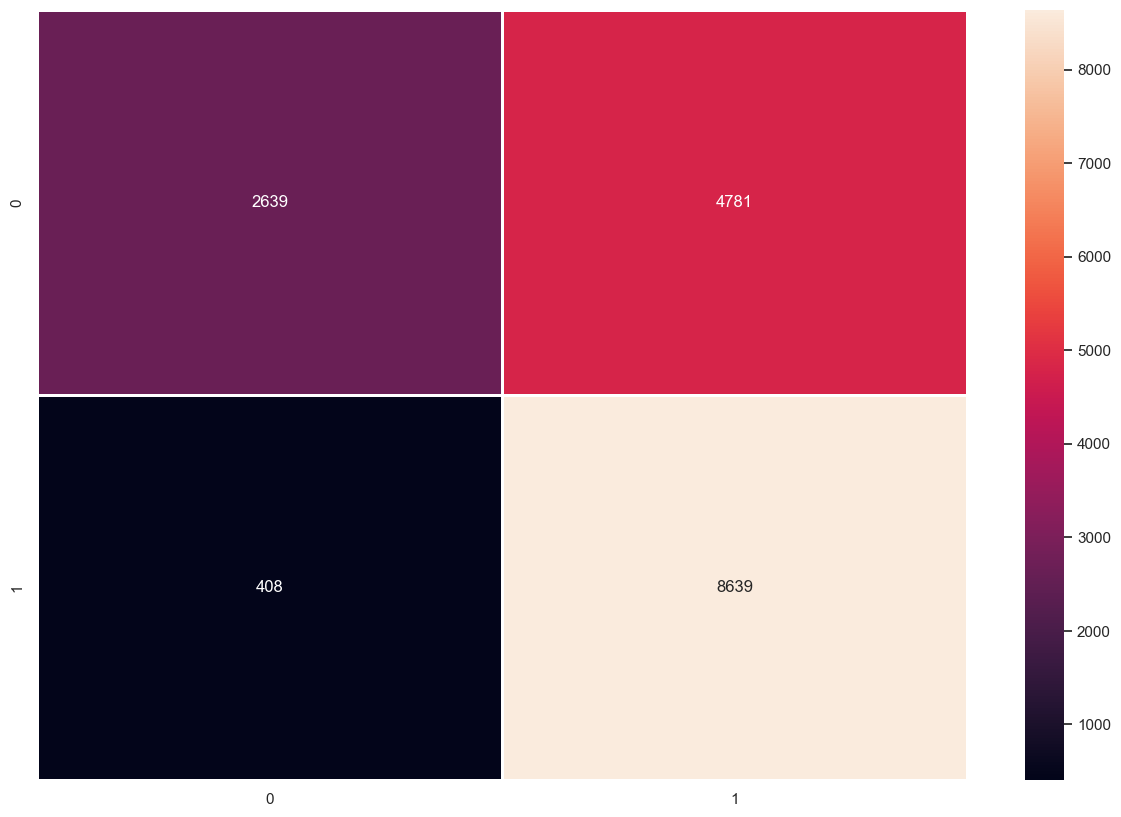

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df_label.drop(['label'], axis=1).to_numpy(), df_label['label'], test_size=0.2)

nb_label = GaussianNB().fit(X_train,y_train)
y_pred = nb_label.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
print(accuracy_score(y_test, y_pred))

<AxesSubplot:>

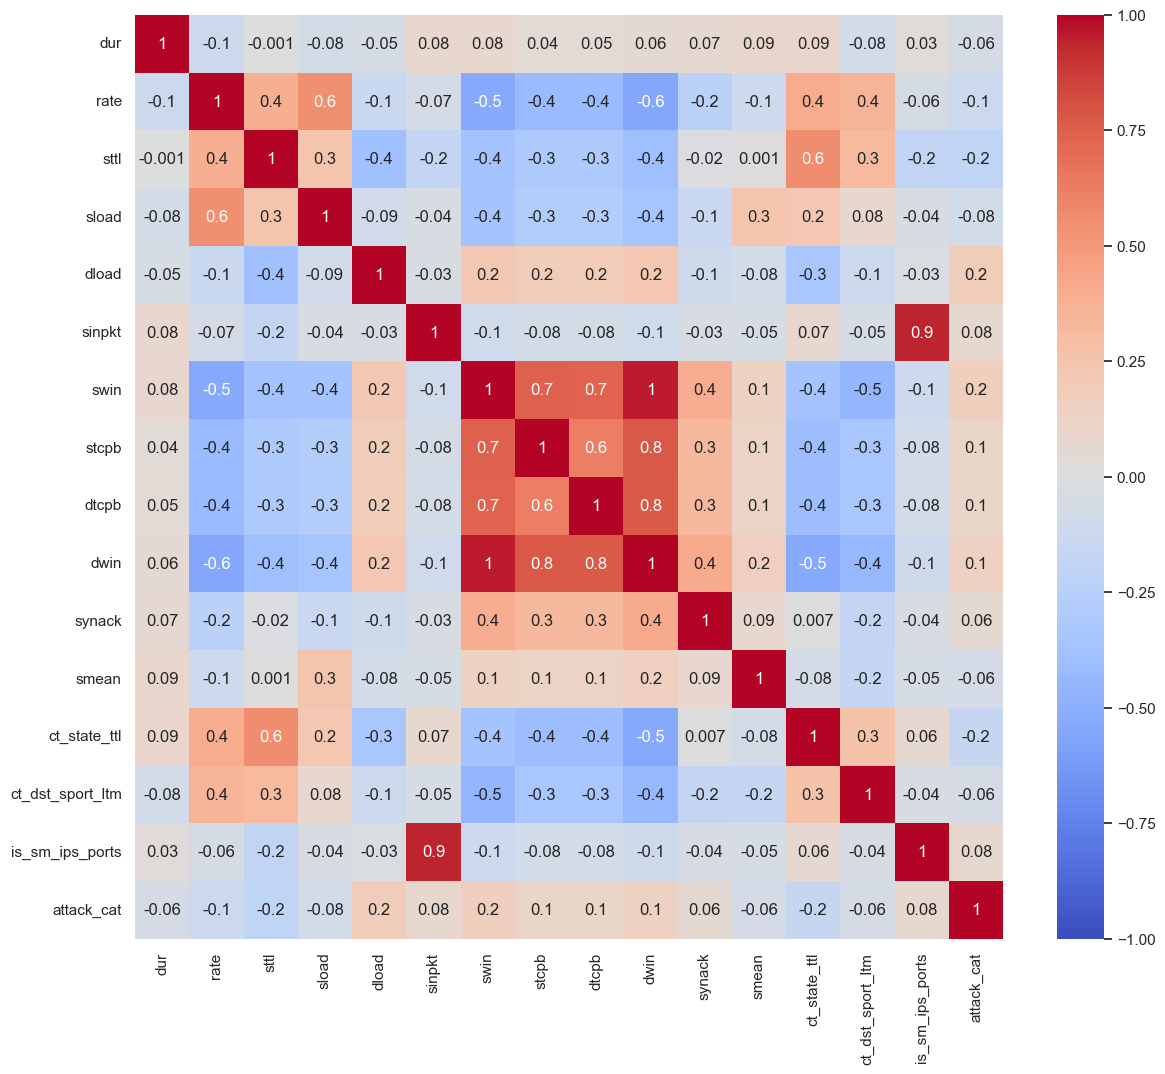

In [26]:
df_cat = df.drop(
    [k for k,v in  (df.drop(['label','attack_cat'], axis=1).corrwith(df['attack_cat']).abs().sort_values(ascending=True) < 0.05).items()  if v],
    axis=1)
df_cat = df_cat.drop(['label','state', 'proto', 'service'], axis=1)

sns.set(rc = {'figure.figsize':(14,12)})
sns.heatmap(df_cat.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

In [ ]:
df_cat_lesscorr = df_cat[['rate','sttl','dload','swin','dmean','ct_state_ttl','ct_dst_src_ltm','attack_cat']]
df_cat_lesscorr.head()

0.4284933503370377


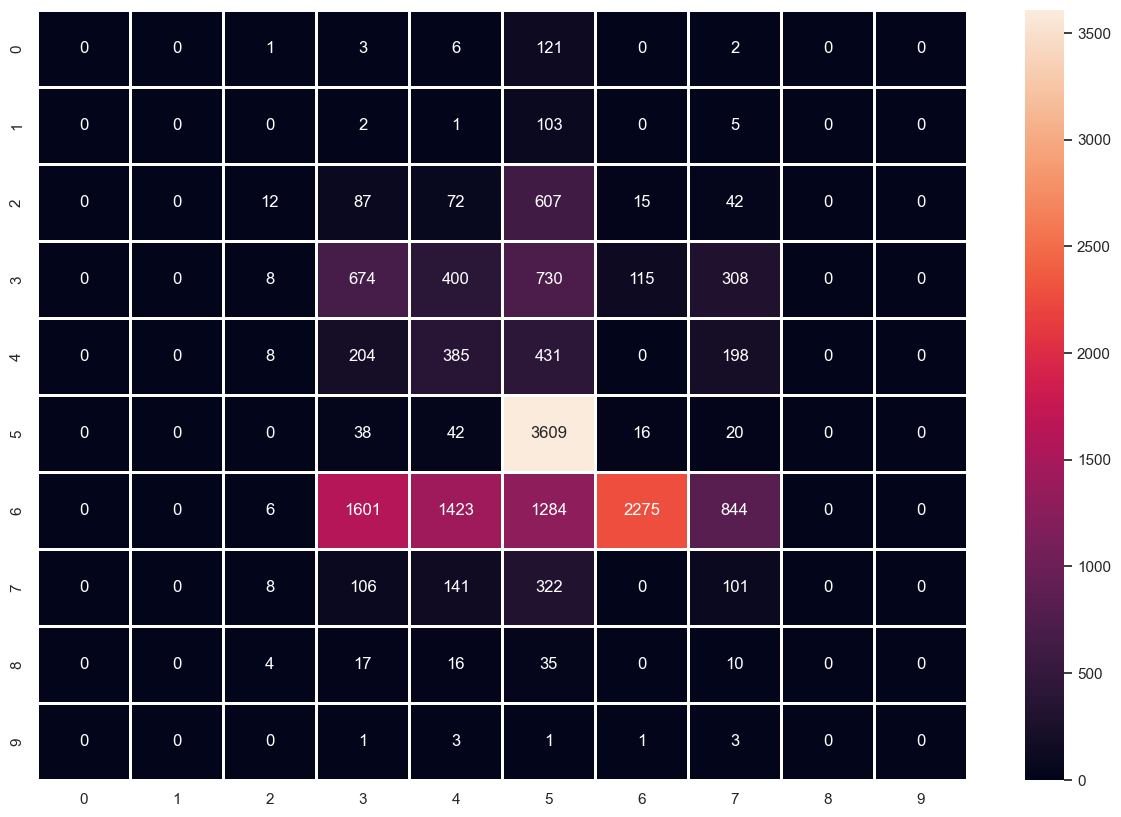

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df_cat.drop(['attack_cat'], axis=1).to_numpy(), df_cat['attack_cat'], test_size=0.2)

X_train, y_train =  BorderlineSMOTE().fit_resample(X,y)

nb_cat = GaussianNB().fit(X_train,y_train)
y_pred = nb_cat.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
print(accuracy_score(y_test, y_pred))